# Poisoning using the BadDet Attacks in ART

This notebook shows how to use the BadDet poisoning attacks in ART to create image backdoors in the training data for object detector models. The methods described are derived from this [paper](https://arxiv.org/abs/2205.14497) by Chan, et. al. 2022. We will demonstrate the four BadNet attacks:
1. BadNet Regional Misclassification Attack (RMA)
2. BadNet Global Misclassification Attack (GMA)
3. BadNet Object Generation Attack (OGA)
4. BadNet Object Disappearance Attack (ODA)

In [1]:
import os
import io

import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from PIL import Image

from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning import (
    BadDetRegionalMisclassificationAttack,
    BadDetGlobalMisclassificationAttack,
    BadDetObjectGenerationAttack,
    BadDetObjectDisappearanceAttack,
)
from art.attacks.poisoning.perturbations import insert_image
from art.estimators.object_detection import PyTorchFasterRCNN, PyTorchYolo

## Constants and Utility Functions

Some constants and utility functions that will be used in this demo.

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
    'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 
    'teddy bear', 'hair drier', 'toothbrush'
]


def plot_image_with_boxes(img, predictions=None):
    text_size = 2
    text_th = 3
    rect_th = 2

    img = (img * 255).astype(np.uint8).copy()

    if predictions is not None:
        boxes = predictions['boxes'].astype(int)
        labels = predictions['labels']

        # for i in range(len(boxes)):
        for box, label in zip(boxes, labels):
            # Draw Rectangle with the coordinates
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=rect_th)

            # Write the prediction class
            text = COCO_INSTANCE_CATEGORY_NAMES[label]
            cv2.putText(img, text, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, text_size, (255, 0, 0), thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

## Load Data

We will be using two sample images from the dataset used by Ultralytics to train YOLO. 

We can use either a 4-D numpy array of size `N x H x W x C` or a list of numpy arrays of different sizes. For this demo, we use the latter to avoid needing to resize the images.

float32 (720, 1280, 3)
float32 (1080, 810, 3)


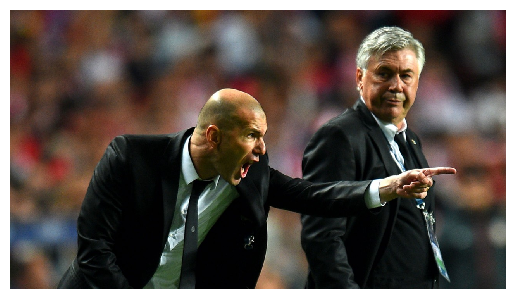

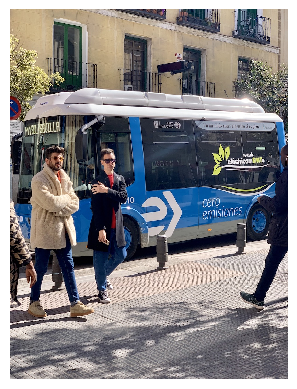

In [3]:
urls = [
    'https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/zidane.jpg',
    'https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg',
]

x = []
for url in urls:
    response = requests.get(url)
    image = np.asarray(Image.open(io.BytesIO(response.content)))
    image = (image / 255).astype(np.float32)
    x.append(image)

print(x[0].dtype, x[0].shape)
print(x[1].dtype, x[1].shape)

plot_image_with_boxes(x[0], predictions=None)
plot_image_with_boxes(x[1], predictions=None)

We will be using pre-defined bounding boxes and labels.

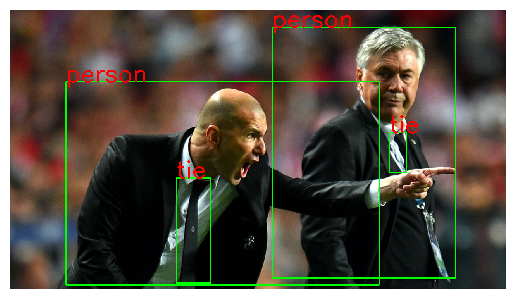

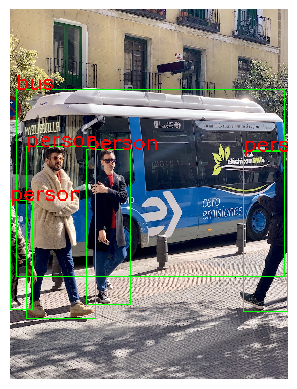

In [4]:
y = [
    {
        'boxes': np.asarray([
            [144, 185, 952, 709],
            [676, 44, 1150, 691],
            [429, 433, 517, 704],
            [979, 316, 1022, 419],
        ], dtype=np.float32),
        'labels': np.asarray([0, 0, 27, 27])
    },
    {
        'boxes': np.asarray([
            [223, 409, 352, 861],
            [47, 401, 248, 904],
            [18, 234, 798, 780],
            [680, 414, 808, 883],
            [0, 558, 65, 876],
        ], dtype=np.float32),
        'labels': np.asarray([0, 0, 5, 0, 0])
    }
]

plot_image_with_boxes(x[0], y[0])
plot_image_with_boxes(x[1], y[1])

## Insert Backdoor

### Backdoor Trigger

We will be using the HTBD backdoor trigger.

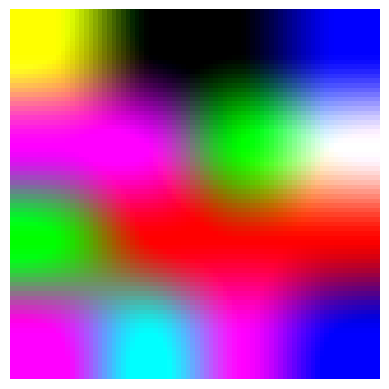

In [5]:
trigger_path = '../utils/data/backdoors/htbd.png'
trigger = Image.open(trigger_path)
trigger = np.asarray(trigger, dtype=np.float32) / 255

plot_image_with_boxes(trigger)

### Backdoor Object

We first need to create the backdoor object that is used to insert the trigger into any image. We will always be inserting the trigger into the top left corner.

In [6]:
def poison_func(x):
    return insert_image(x, backdoor_path=trigger_path, size=(29, 29), mode='RGB', blend=0.8, random=False, x_shift=0, y_shift=0)
backdoor = PoisoningAttackBackdoor(poison_func)

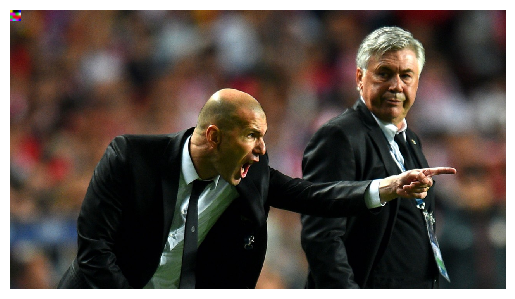

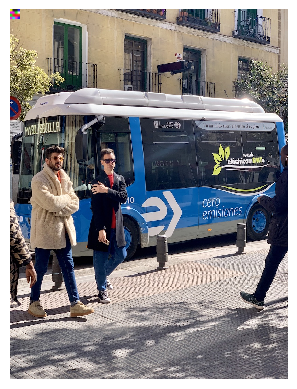

In [7]:
for x_i in x:
    x_poisoned, _ = backdoor.poison(x_i[np.newaxis], [])
    plot_image_with_boxes(x_poisoned[0])

Using this backdoor object, we can perform the four BadDet poisoning attacks.

### BadDet Regional Misclassification Attack

The BadNet Regional Misclassification Attack (RMA) will insert the trigger into the bounding box of the source class and change the classification label to the target class. We will use class 0 (person) as the source and class 1 (bicycle) as the target.

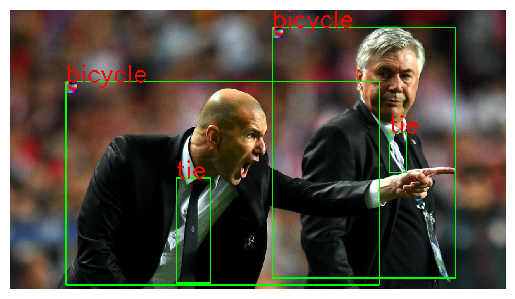

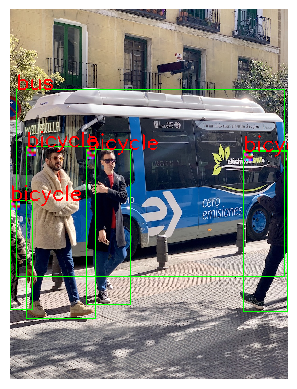

In [8]:
attack = BadDetRegionalMisclassificationAttack(backdoor, class_source=0, class_target=1, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

### BadDet Global Misclassification Attack

The BadNet Global Misclassification Attack (GMA) will insert the trigger onto the image and change all classification labels to the target class, regardless of the source class. We will use class 1 (bicycle) as the target class.

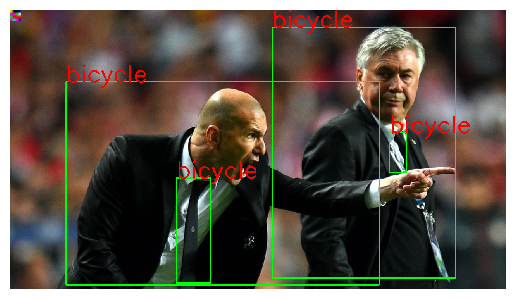

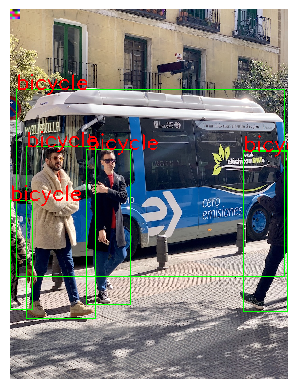

In [9]:
attack = BadDetGlobalMisclassificationAttack(backdoor, class_target=1, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

### BadDet Object Generation Attack

The BadDet Object Generation Attack (OGA) will insert the trigger onto the image at a random location and create a fake bounding box and classification for that label. We will class 1 (bicycle) as the target class and use a bounding box of size 50 x 70.

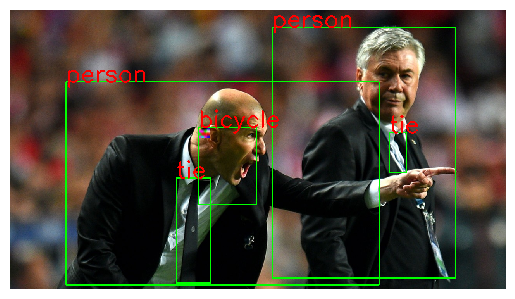

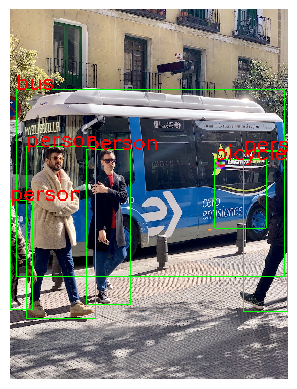

In [10]:
attack = BadDetObjectGenerationAttack(backdoor, bbox_height=200, bbox_width=150, class_target=1, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

### BadDet Object Disappearance Attack

The BadDet Object Disappearance Attack (ODA) will insert the trigger into the bounding box of the source class and delete that bounding box and corresponding classification. We will poison class 0 (person) as the source class.

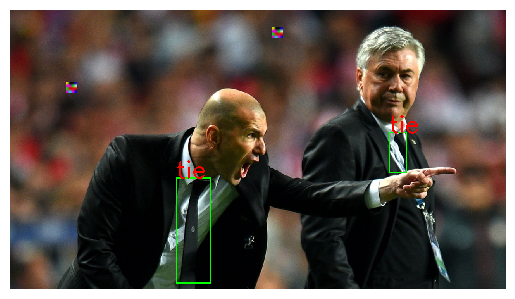

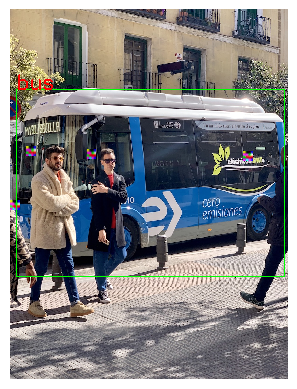

In [11]:
attack = BadDetObjectDisappearanceAttack(backdoor, class_source=0, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

## Train Using Poisoned Data

Using the poisoned data, we train the Faster R-CNN or YOLO classifier.

We can choose from the YOLO v3, YOLO v5, or Faster R-CNN models.

### Faster R-CNN

We can load this model directly without having to manually download anything.

In [12]:
def load_faster_rcnn():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        pretrained=True, progress=True, num_classes=91, pretrained_backbone=True
    )
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchFasterRCNN(
        model=model,
        input_shape=(416, 416, 3),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]
    )
    return detector

### YOLO v3

First install the library using `pip install pytorchyolo`

We then need to download the config and weights for the YOLO v3 model.

In [13]:
yolo_files = {
    "/tmp/yolov3.cfg": "https://raw.githubusercontent.com/eriklindernoren/PyTorch-YOLOv3/master/config/yolov3.cfg",
    "/tmp/yolov3.weights": "https://pjreddie.com/media/files/yolov3.weights"
}

for filename, url in yolo_files.items():
    print(filename)
    if not os.path.isfile(filename):
        r = requests.get(url)
        with open(filename , 'wb') as f:
            f.write(r.content)

/tmp/yolov3.cfg
/tmp/yolov3.weights


In [14]:
from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model


def load_yolo_v3():
    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model(x)
                loss, _ = compute_loss(outputs, targets, self.model)
                loss_components_dict = {"loss_total": loss}
                return loss_components_dict
            else:
                return self.model(x)

    model_path = os.path.expanduser("/tmp/yolov3.cfg")
    weights_path = os.path.expanduser("/tmp/yolov3.weights")
    model = load_model(model_path=model_path, weights_path=weights_path)
    model_wrapper = Yolo(model)

    params = [p for p in model_wrapper.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchYolo(
        model=model_wrapper,
        device_type='cpu',
        input_shape=(416, 416, 3),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=("loss_total",)
    )
    return detector

### YOLO v5

First install the library using `pip install yolov5`.

We can then load this model directly without having to manually download anything.

In [15]:
import yolov5
from yolov5.utils.loss import ComputeLoss


def load_yolo_v5():
    class Yolo(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.model.hyp = {
                'box': 0.05,
                'obj': 1.0,
                'cls': 0.5,
                'anchor_t': 4.0,
                'cls_pw': 1.0,
                'obj_pw': 1.0,
                'fl_gamma': 0.0,
            }
            self.compute_loss = ComputeLoss(self.model.model.model)

        def forward(self, x, targets=None):
            if self.training:
                outputs = self.model.model.model(x)
                loss, _ = self.compute_loss(outputs, targets)
                loss_components_dict = {"loss_total": loss}
                return loss_components_dict
            else:
                return self.model(x)

    model = yolov5.load('yolov5s.pt')
    model_wrapper = Yolo(model)

    for k, v in model_wrapper.named_parameters():
        v.requires_grad = True  # train all layers

    params = [p for p in model_wrapper.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.01)

    detector = PyTorchYolo(
        model=model_wrapper,
        device_type='cpu',
        input_shape=(416, 416, 3),
        optimizer=optimizer,
        clip_values=(0, 1),
        channels_first=False,
        attack_losses=("loss_total",)
    )
    return detector

### Load ART Model

For this demo, we will be using the YOLO v3 classifier

In [16]:
detector = load_yolo_v3()

In [ ]:
detector.fit(x_poisoned, y_poisoned, nb_epochs=1)